# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [1]:
from tqdm.auto import tqdm
import optuna

In [2]:
from sklearn.model_selection import train_test_split,cross_val_score

In [3]:
import os
import pickle
import emnist
import pandas as pd
from sklearn.metrics import accuracy_score

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [5]:
import numpy as np
import matplotlib.pyplot as plt

### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [6]:
imgtrain, labtrain = emnist.extract_training_samples('balanced')
imgtest, labtest = emnist.extract_test_samples('balanced')

In [7]:
print(f'Train: {len(imgtrain)} samples')
print(f'Test: {len(imgtest)} samples')
print(f'Image size: {imgtrain.data.shape[1]}x{imgtrain.data.shape[2]}')

Train: 112800 samples
Test: 18800 samples
Image size: 28x28


In [8]:
labelz = {}
with open('emnist-balanced-mapping.txt', 'r') as f:
    for i in f:
        label, ANCII = i.split()
        labelz[int(label)] = chr(int(ANCII))

In [9]:
np.unique(labtrain, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=uint8),
 array([2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400], dtype=int64))

In [10]:
np.unique(labtest, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=uint8),
 array([400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400,
        400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400,
        400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400,
        400, 400, 400, 400, 400, 400, 400, 400], dtype=int64))

<font color="green" style="font-size:16px"><b>В трейне по 2400 каждого, в тесте по 400</b></font>

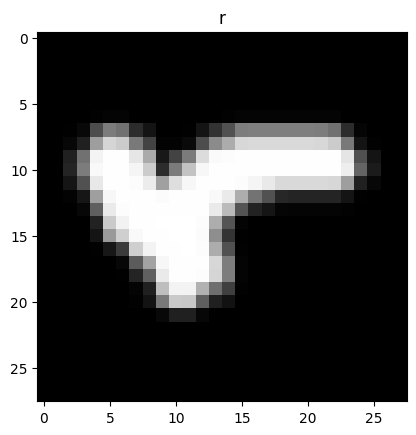

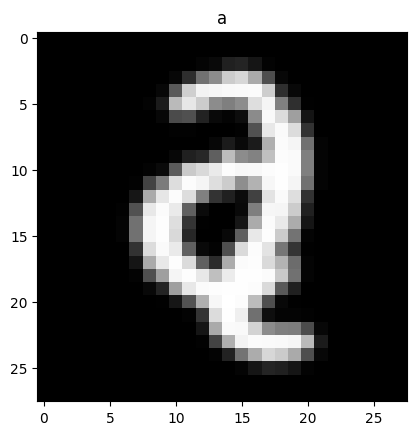

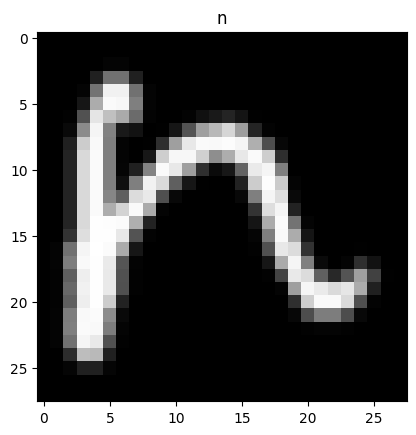

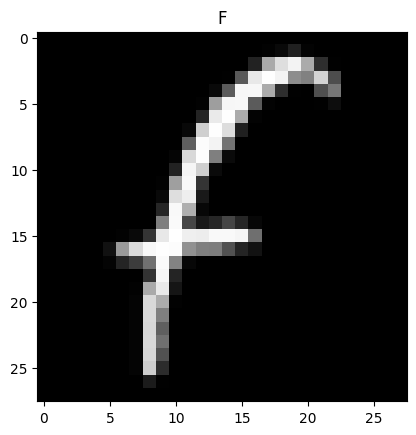

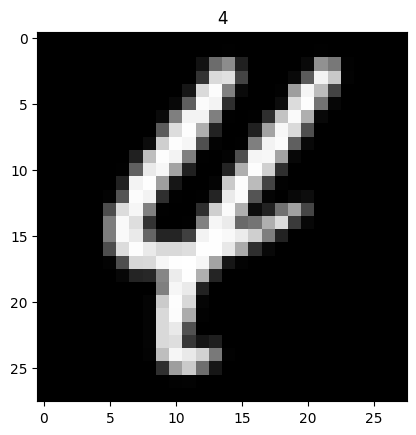

In [11]:
for i in range(5):
    plt.imshow(imgtrain[i], cmap='gray')
    plt.title(labelz[labtrain[i]])
    plt.show()

### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

In [12]:
Xtrain = imgtrain.reshape(imgtrain.shape[0],-1)
ytrain = labtrain.reshape(labtrain.shape[0],-1)
Xtest = imgtest.reshape(imgtest.shape[0],-1)
ytest = labtest.reshape(labtest.shape[0],-1)

ytest = ytest.ravel()
ytrain = ytrain.ravel()

Xtrain = Xtrain.astype(np.float32)
Xtrain /= 255.0
Xtest = Xtest.astype(np.float32)
Xtest /= 255.0

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((112800, 784), (18800, 784), (112800,), (18800,))

In [32]:
Xtrain_s, Xtest_b, ytrain_s, ytest_b = train_test_split(Xtrain, ytrain, test_size=0.5, random_state=42)
Xtrain_s, Xval, ytrain_s, yval = train_test_split(Xtrain_s, ytrain_s, test_size=0.2, random_state=42)
Xtrain_s.shape, Xval.shape, ytrain_s.shape, yval.shape

((45120, 784), (11280, 784), (45120,), (11280,))

### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

In [14]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [33]:
stat2 = pd.DataFrame(columns=['model', 'cv', 'accuracy_test'])

lgbm
----

In [35]:
LGBMC = LGBMClassifier(random_seed=42,force_col_wise=True, objective='multiclass')
LGBMC.fit(Xtrain_s, ytrain_s, eval_set = [(Xval, yval)])

pred_test = LGBMC.predict(Xtest)
accuracy_test = accuracy_score(ytest,pred_test)

scores = cross_val_score(LGBMC, Xtrain_s, ytrain_s, cv=5, scoring = 'accuracy')

res = pd.DataFrame({
    'model': [LGBMC],
    'cv': [np.mean(scores)],
    'accuracy_test': [accuracy_test]
    })
stat2 = pd.concat([stat2, res]).reset_index(drop=True)

In [36]:
stat2

,model,cv,accuracy_test
0,"LGBMClassifier(force_col_wise=True, objective=...",0.782159,0.780372


In [37]:
pred_test_one = LGBMC.predict(Xtest_b)
accuracy_test_one = accuracy_score(ytest_b,pred_test_one)
accuracy_test_one

0.7828191489361702

In [41]:
pred_test_one

array([12, 28, 17, ...,  9,  8, 35], dtype=uint8)

In [38]:
sum(ytest_b == pred_test_one)/len(ytest_b)

0.7828191489361702

In [39]:
diff_pred1 = pd.DataFrame({'real':ytest_b, 'predict': pred_test_one})
fails1 = diff_pred1[diff_pred1['real']!=diff_pred1['predict']]['real']
print(f'the worst 10 predicts made for the following symbols:\
 {[labelz[i] for i in fails1.value_counts().head(10).index.tolist()]}')

the worst 10 predicts made for the following symbols: ['g', 'L', 'q', 'f', 'F', '1', 'I', 'O', '0', '9']


In [ ]:
def objective_LGBMClassifier(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 200),
        'reg_alpha': trial.suggest_int('reg_alpha', 10, 70),
        'reg_lambda': trial.suggest_int('reg_lambda', 20, 200)
    }
    
    model = LGBMClassifier(random_state=42, force_col_wise=True,
                          **params)
    model.fit(Xtrain_s, ytrain_s)
    preds = model.predict(Xtest)

    return accuracy_score(ytest,preds)

study_LGBMClassifier = optuna.create_study(direction='maximize', pruner='MedianPruner')
study_LGBMClassifier.optimize(objective_LGBMClassifier, n_trials=50)
print('Best one:', study_LGBMClassifier.best_trial.params, study_LGBMClassifier.best_value)
os.system(f'telegram-send "study_LGBMClassifier best score:{study_LGBMClassifier.best_value}"')

other models
-----

In [34]:
CB = CatBoostClassifier(iterations=100, eval_metric='Accuracy', early_stopping_rounds=10, objective='MultiClassOneVsAll')
CB.fit(Xtrain_s, ytrain_s, eval_set = [(Xval, yval)])

pred_train = CB.predict(Xtrain_s)
pred_test = CB.predict(Xtest)

accuracy_train = accuracy_score(ytrain_s,pred_train)
accuracy_test = accuracy_score(ytest,pred_test)

res = pd.DataFrame({
    'model': [CB],
    'accuracy_train': [accuracy_train],
    'accuracy_test': [accuracy_test]
    })
stat = pd.concat([stat, res]).reset_index(drop=True)

0:	learn: 0.1026891	test: 0.1046099	best: 0.1046099 (0)	total: 9.97s	remaining: 16m 27s
1:	learn: 0.1692893	test: 0.1566194	best: 0.1566194 (1)	total: 19.9s	remaining: 16m 16s
2:	learn: 0.2200798	test: 0.2108452	best: 0.2108452 (2)	total: 30.5s	remaining: 16m 26s
3:	learn: 0.2529551	test: 0.2381797	best: 0.2381797 (3)	total: 40.8s	remaining: 16m 18s
4:	learn: 0.2670656	test: 0.2470449	best: 0.2470449 (4)	total: 50.6s	remaining: 16m 1s
5:	learn: 0.3120567	test: 0.2921099	best: 0.2921099 (5)	total: 1m	remaining: 15m 53s
6:	learn: 0.3449320	test: 0.3206265	best: 0.3206265 (6)	total: 1m 10s	remaining: 15m 40s
7:	learn: 0.3680925	test: 0.3448582	best: 0.3448582 (7)	total: 1m 20s	remaining: 15m 24s
8:	learn: 0.3742982	test: 0.3519504	best: 0.3519504 (8)	total: 1m 30s	remaining: 15m 11s
9:	learn: 0.3843085	test: 0.3605201	best: 0.3605201 (9)	total: 1m 40s	remaining: 15m
10:	learn: 0.4156693	test: 0.3983452	best: 0.3983452 (10)	total: 1m 50s	remaining: 14m 53s
11:	learn: 0.4338061	test: 0.4126

In [35]:
CB2 = CatBoostClassifier(iterations=100, eval_metric='Accuracy', early_stopping_rounds=10, random_seed=42)
CB2.fit(Xtrain_s, ytrain_s, eval_set = [(Xval, yval)])

pred_train = CB2.predict(Xtrain_s)
pred_test = CB2.predict(Xtest)

accuracy_train = accuracy_score(ytrain_s,pred_train)
accuracy_test = accuracy_score(ytest,pred_test)

res = pd.DataFrame({
    'model': [CB2],
    'accuracy_train': [accuracy_train],
    'accuracy_test': [accuracy_test]
    })
stat = pd.concat([stat, res]).reset_index(drop=True)

Learning rate set to 0.277957
0:	learn: 0.2183067	test: 0.2089243	best: 0.2089243 (0)	total: 9.92s	remaining: 16m 22s
1:	learn: 0.2802527	test: 0.2665485	best: 0.2665485 (1)	total: 19.8s	remaining: 16m 11s
2:	learn: 0.3645833	test: 0.3507683	best: 0.3507683 (2)	total: 29.7s	remaining: 16m
3:	learn: 0.4214317	test: 0.4027778	best: 0.4027778 (3)	total: 40s	remaining: 15m 59s
4:	learn: 0.4680482	test: 0.4463652	best: 0.4463652 (4)	total: 49.7s	remaining: 15m 44s
5:	learn: 0.4981161	test: 0.4729610	best: 0.4729610 (5)	total: 59.4s	remaining: 15m 30s
6:	learn: 0.5248596	test: 0.4991135	best: 0.4991135 (6)	total: 1m 8s	remaining: 15m 16s
7:	learn: 0.5461362	test: 0.5152187	best: 0.5152187 (7)	total: 1m 18s	remaining: 15m 1s
8:	learn: 0.5666002	test: 0.5344267	best: 0.5344267 (8)	total: 1m 27s	remaining: 14m 49s
9:	learn: 0.5882831	test: 0.5515662	best: 0.5515662 (9)	total: 1m 37s	remaining: 14m 36s
10:	learn: 0.6014332	test: 0.5639775	best: 0.5639775 (10)	total: 1m 46s	remaining: 14m 25s
11:

In [41]:
LogReg = LogisticRegression(random_state=42, solver='saga',multi_class='multinomial')
LogReg.fit(Xtrain_s, ytrain_s)

pred_train = LogReg.predict(Xtrain_s)
pred_test = LogReg.predict(Xtest)

accuracy_train = accuracy_score(ytrain_s,pred_train)
accuracy_test = accuracy_score(ytest,pred_test)

res = pd.DataFrame({
    'model': [LogReg],
    'accuracy_train': [accuracy_train],
    'accuracy_test': [accuracy_test]
    })
stat = pd.concat([stat, res]).reset_index(drop=True)

c:\Users\ESC\.conda\envs\p3119\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ESC\.conda\envs\p3119\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [59]:
stat

,model,accuracy_train,accuracy_test
0,cb_ova,0.617538,0.589149
1,cb_mult,0.786421,0.700904
2,logreg_mult,0.761636,0.655000
3,lgbmc_mult,1.000000,0.762447
4,logreg_mult,0.777889,0.657606


In [63]:
optuna.importance.get_param_importances(study_LGBMClassifier)

{'reg_alpha': 0.5732563327292344,
 'n_estimators': 0.20583518973591577,
 'reg_lambda': 0.10353129781739594,
 'colsample_bytree': 0.07211058720514611,
 'min_child_weight': 0.04040003194369667,
 'max_depth': 0.004866560568611221}

In [129]:
def objective_CBC(trial):
    
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.001,0.01,0.1,0.5]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])
    }
    
    model = CatBoostClassifier(eval_metric='Accuracy', early_stopping_rounds=10, random_seed=42, **params)
    model.fit(Xtrain_s, ytrain_s, eval_set=[(Xval, yval)])
    preds = model.predict(Xtest)

    return accuracy_score(ytest,preds)

study_CBC = optuna.create_study(direction="maximize")
study_CBC.optimize(objective_CBC, n_trials=50, timeout=600)

0:	learn: 0.1805925	test: 0.1625296	best: 0.1625296 (0)	total: 1.68s	remaining: 28m
1:	learn: 0.2842790	test: 0.2721631	best: 0.2721631 (1)	total: 3.13s	remaining: 26m 1s
2:	learn: 0.3290854	test: 0.3104314	best: 0.3104314 (2)	total: 4.67s	remaining: 25m 53s
3:	learn: 0.3655437	test: 0.3432329	best: 0.3432329 (3)	total: 5.97s	remaining: 24m 45s
4:	learn: 0.3940972	test: 0.3671690	best: 0.3671690 (4)	total: 7.51s	remaining: 24m 55s
5:	learn: 0.4135638	test: 0.3874113	best: 0.3874113 (5)	total: 9.03s	remaining: 24m 56s
6:	learn: 0.4433732	test: 0.4196217	best: 0.4196217 (6)	total: 10.5s	remaining: 24m 56s
7:	learn: 0.4564125	test: 0.4382388	best: 0.4382388 (7)	total: 12s	remaining: 24m 52s
8:	learn: 0.4753620	test: 0.4541962	best: 0.4541962 (8)	total: 13.6s	remaining: 24m 56s
9:	learn: 0.4780585	test: 0.4626182	best: 0.4626182 (9)	total: 15.1s	remaining: 24m 58s
10:	learn: 0.4891401	test: 0.4694149	best: 0.4694149 (10)	total: 16.8s	remaining: 25m 10s
11:	learn: 0.4968602	test: 0.4815307	

aml
----

In [68]:
from lightautoml.automl.base import AutoML
from lightautoml.tasks import Task

from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.ml.base import MLPipeline

from lightautoml.reader.base import PandasToPandasReader

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


C:\Users\ESC\AppData\Roaming\Python\Python311\site-packages\lightautoml\text\tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
C:\Users\ESC\AppData\Roaming\Python\Python311\site-packages\lightautoml\transformers\text.py:22: UserWarning: 'gensim' - package isn't installed
  warnings.warn("'gensim' - package isn't installed")
C:\Users\ESC\AppData\Roaming\Python\Python311\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [69]:
train_data = pd.DataFrame(Xtrain_s)
train_data['target'] = ytrain_s

test_data = pd.DataFrame(Xtest)
test_data['target'] = ytest

train_data.columns = [str(i) for i in train_data.columns]
test_data.columns = [str(i) for i in test_data.columns]

N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TARGET_NAME = 'target'

TIMEOUT = 3600
task = Task('multiclass')
roles = {
    'target': TARGET_NAME
}

In [ ]:

reader = PandasToPandasReader(task, cv=N_FOLDS, random_state=RANDOM_STATE)

pipe = LGBSimpleFeatures()

params_tuner1 = OptunaTuner(n_trials=20, timeout=30)

model1 = BoostLGBM(
    default_params={'learning_rate':0.05, 'num_leaves': 128, 'seed': RANDOM_STATE, 'num_threads': N_THREADS}
)
model2 = BoostLGBM(
    default_params={'learning_rate':0.02, 'num_leaves': 64, 'seed': RANDOM_STATE, 'num_threads': N_THREADS}
)

pipeline_lvl1 = MLPipeline([
    model1,
    model2],
    pre_selection=None, 
    features_pipeline=pipe,
    post_selection=None
)

pipe1 = LGBSimpleFeatures()
model3 = BoostCB()

pipeline_lvl2 = MLPipeline(
    [(model3, params_tuner1)], 
    pre_selection=None, 
    features_pipeline=pipe1,
    post_selection=None
)

automl = AutoML(reader, [
    [pipeline_lvl1],
    [pipeline_lvl2],], 
    skip_conn=False)


oof_pred3 = automl.fit_predict(train_data, roles=roles)
test_pred3 = automl.predict(test_data)

result_test = np.argmax(test_pred3.data, axis=1)
result_train = np.argmax(oof_pred3.data, axis=1)

accuracy_train = accuracy_score(train_data[TARGET_NAME].values, result_train)
accuracy_test = accuracy_score(test_data[TARGET_NAME].values, result_test)

In [98]:
print(f'train score: {accuracy_train}')
print(f'test score: {accuracy_test}')

train score: 0.763815011820331
test score: 0.7743085106382979


WORST PREDICTABLE SYMBOLS:
-----

In [108]:
diff_pred = pd.DataFrame({'real':test_data[TARGET_NAME].values, 'predict': result_test})

In [111]:
fails = diff_pred[diff_pred['real']!=diff_pred['predict']]['real']

In [121]:
fails.value_counts().head(10).index.tolist()

[44, 41, 21, 15, 18, 24, 1, 0, 40, 34]

In [128]:
print(f'the worst 10 predicts made for the following symbols:\
 {[labelz[i] for i in fails.value_counts().head(10).index.tolist()]}')

the worst 10 predicts made for the following symbols: ['q', 'g', 'L', 'F', 'I', 'O', '1', '0', 'f', 'Y']


to_pkl
----

In [40]:
with open(os.path.join('myapp', 'model_lgbm.pkl'),'wb') as f:
    pickle.dump(LGBMC, f)